# CCLM2 Nature Futures
-----------------
Produces Fig. 6 and supplementary Fig. 5

In [1]:
import warnings
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

# Custom settings and functions
from settings import *
from plotting import *
from func_calc import *
from func_stats import *
from func_plots import *

# Mute warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
set_plot_param()
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None, 'facecolor': '1'} # display figues as exported to PDF without 'tight'

# Settings

In [3]:
# Save to
os.makedirs('Figures/sensitivity/', exist_ok=True)

In [4]:
perturb_levels = ['0-10%', '10-30%', '30-50%', '50-100%']
region_order = ['EU+', 'North', 'West', 'East', 'South']

In [5]:
# Surface datasets
file = 'surf.nc'
surf_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file)
surf_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file)
surf_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file)
surf_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file)

area = surf_ssp1.AREA

In [6]:
# Mask of potentially modified grid cells, based on EUNIS habitat mapping area (EU+)
eunis = xr.open_dataarray(dpath_proc + 'eunis_mask_repr.nc')

# Region mask
mask_2D = xr.open_dataarray(dpath_proc + 'regionmask_2D_Dou.nc')
mask_3D = xr.open_dataarray(dpath_proc + 'regionmask_3D_Dou.nc')
region_dict = {0: 'North', 1: 'West', 2: 'East', 3: 'South'}

# Combine subregins and EU+ into one mask
eunis_mask = xr.where(eunis==1, True, False).rename('EU+') # convert to a boolean mask
eunis_mask = eunis_mask.expand_dims('region').assign_coords(region=['EU+']) # add region dimension
mask_3D_eu = xr.concat([eunis_mask, mask_3D], dim='region') # combine to joint mask

# Functions

In [7]:
# Aggregate by perturbation level and region
# Climatology of ALL cells; space dimension maintained
# Can be seasonal, annual, or no time-dimension (e.g. JJA subset)
def clim(ds, surf):
    ds_1 = ds.where(surf['pct_change']<10)
    ds_2 = ds.where((surf['pct_change']>=10) & (surf['pct_change']<30))
    ds_3 = ds.where((surf['pct_change']>=30) & (surf['pct_change']<50))
    ds_4 = ds.where(surf['pct_change']>=50)   
    ds = xr.concat([ds_1, ds_2, ds_3, ds_4], dim='perturb').assign_coords({'perturb': ('perturb', perturb_levels)})
    ds = ds.assign(region=mask_2D)

    # Dataframe
    # Subregions
    df = ds.to_dataframe().dropna(how='any') # drop nans among variables (there are more cells for COSMO than for CLM output vars)
    df = df.replace({'region': region_dict}) # replace region indices by names    
    # EU+
    ds['region'] = xr.where(eunis==1, 'EU+', np.nan)
    df_eu = ds.to_dataframe().dropna(how='any')
    # Combine
    df = pd.concat([df_eu, df])
    df = df.reset_index().drop(columns=['lat','lon'])

    # Sorting
    df['region'] = pd.Categorical(df['region'], region_order)
    df['perturb'] = pd.Categorical(df['perturb'], perturb_levels)
    df = df.sort_values(['region','perturb'])    
    return df

# Multi-year series per region and perturbation level to test the significance of the mean across years
# Can be seasonal, annual, or no time-dimension (e.g. JJA subset); specify if there is a seasonal dimension
def series(ds, surf, season_dim=False):
    ds_1 = ds.where(surf['pct_change']<10).weighted(mask_3D_eu*area.fillna(0)).mean(dim=['lon','lat'])
    ds_2 = ds.where((surf['pct_change']>=10) & (surf['pct_change']<30)).weighted(mask_3D_eu*area.fillna(0)).mean(dim=['lon','lat'])
    ds_3 = ds.where((surf['pct_change']>=30) & (surf['pct_change']<50)).weighted(mask_3D_eu*area.fillna(0)).mean(dim=['lon','lat'])
    ds_4 = ds.where(surf['pct_change']>=50).weighted(mask_3D_eu*area.fillna(0)).mean(dim=['lon','lat'])    
    ds = xr.concat([ds_1, ds_2, ds_3, ds_4], dim='perturb').assign_coords({'perturb': ('perturb', perturb_levels)})
    if season_dim is True:
        ds = ds.assign_coords({'season': ('time', ds.time.dt.season.values)})
        ds = ds.assign_coords({'year': ('time', ds.time.dt.year.values)})
        ds = ds.drop_vars('time')

    # Dataframe and sorting
    df = ds.to_dataframe().reset_index()
    if season_dim is True:
        df = df.drop(columns='time')
    df['region'] = pd.Categorical(df['region'], region_order)
    df['perturb'] = pd.Categorical(df['perturb'], perturb_levels)
    df = df.sort_values(['region','perturb'])
    return df

In [8]:
# Plot group size and significance level on boxplot
# Significance test on variable from dataframe
def pd_significance(df, var, multitest=False, decide=False):
    from scipy import stats
    import statsmodels as sm
    def _wilcoxon(x):
        return stats.wilcoxon(x, axis=0, nan_policy="omit").pvalue

   # Wilcoxon rank-sum test: non-parametric test for dependent samples
    pvals = df.groupby(['region','perturb'])[var].apply(_wilcoxon)
    
    # Apply Benjamini and Hochberg correction for multiple simultaneous tests (family-wise error rate not used for fdr_bh)
    if multitest is True:
        notnull = np.isfinite(pvals) # exclude and retain nan values
        p_adjust = sm.stats.multitest.multipletests(pvals[notnull], alpha=0.05, method="fdr_bh")[1]
        pvals[notnull] = p_adjust
    
    # Encode significance levels
    if decide is not False:
        pvals.loc[pvals>0.1] = 100 # not significant, set to 0 later
        pvals.loc[pvals<0.01] = 3
        pvals.loc[pvals<0.05] = 2
        pvals.loc[pvals<0.1] = 1
        pvals.loc[pvals==100] = 0
        if decide == 'encode':
            pvals = pvals.replace([3, 2, 1, 0], ['***', '**', '*', ''])
    return pvals

def add_groupsize_labels(ax, handle, df, perturb_levels, region_order, var, whis=None, pad=None, pos=None, showmean=False, signif=False, signif_data=None):
    # Calculate group sizes
    nobs = df.groupby(['region','perturb'])[var].count()
    nobs = nobs.loc[nobs>0] # skip zero because no box will be plotted
    nobs = nobs.reindex(region_order, axis="rows", level=0).reindex(perturb_levels, axis="rows", level=1)
    nobs = nobs.values
    #nobs = [str(x) for x in nobs.tolist()]
    #nobs = ["n= " + i for i in nobs]
    
    # Get horizontal positions
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if "Patch" in str(c)]
    start = 0
    if not boxes:  # seaborn v0.13 => fill=False => no patches => +1 line
        boxes = [c for c in ax.get_lines() if len(c.get_xdata()) == 5]
        start += 1
    lines_per_box = len(lines) // len(boxes)
    
    # Get vertical positions: extract statistics used to draw a series of box and whisker plots
    if (pos is not None) or (signif is True):
        data = df.pivot(columns=['region','perturb'], values=var)
        df_stats = [mpl.cbook.boxplot_stats(data[col].dropna().values, whis=whis)[0] for col in data.columns]
        stats = pd.DataFrame(df_stats, index=data.columns).iloc[:, [1, 4, 5, 7, 8, 9]] # select relevant stats
        stats = stats.reset_index().groupby(['region','perturb']).mean().dropna()
        stats = stats.reindex(region_order, axis="rows", level=0).reindex(perturb_levels, axis="rows", level=1)
        whishi = stats['whishi'].values
        signif_pad = whishi.max()/15
        if stats['iqr'].max() >0.6:
            signif_pad = max(0.15, whishi.max()/15) # ensure it is not to small

    # Test significance (with adjustment for multiple testing across regions and groups)
    if signif is True:
        pvals = pd_significance(signif_data, var, multitest=True, decide='encode')
        pvals = pvals.reindex(region_order, axis="rows", level=0).reindex(perturb_levels, axis="rows", level=1)
        pvals = pvals.values

    # Calculate area-weighted mean
    if showmean is True:
        mean = signif_data.groupby(['region','perturb'])[var].mean()
        mean = mean.reindex(region_order, axis="rows", level=0).reindex(perturb_levels, axis="rows", level=1)

    # Add lables per box
    for i,median_line in enumerate(lines[start::lines_per_box]):
        x, y = (data.mean() for data in median_line.get_data()) # y is median line
        
        if pos is not None: # fixed labelling position on the y axis
            text = ax.text(x, pos, '{:,}'.format(nobs[i]), ha='center', va='bottom', rotation='vertical', fontweight='normal', color='black', size=4.5)
            
        if pad is not None: # dependent on whisher and padding 
            text = ax.text(x, whishi[i]+pad, '{:,}'.format(nobs[i]), ha='center', va='bottom', rotation='vertical', fontweight='normal', color='black', size=4.5)

        if signif is True: # add stars to indicate significance level (dependent on whisher an padding)
            text = ax.text(x, whishi[i]+signif_pad, pvals[i], ha='left', va='bottom', rotation='vertical', fontweight='normal', color='black', size=5)

        if showmean is True:
            text = ax.text(x, mean[i], "×", ha='center', va='center', rotation='horizontal', fontweight='normal', color='black', size=5)

# Boxplot by perturbation level and region

## Data processing

In [9]:
# Climate for combined analysis (annual, TXx, JJA)
# Annual vars (GPP)
variables = ['GPP'] # 'TOTSOILWATER'
file = 'cclm2_annual-climatology.nc'
ds_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file)[variables]
ds_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file)[variables]
ds_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file)[variables]
ds_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file)[variables]

# TXx (annual maximum value of daily max temperature)
file = 'cosmo_T2m-max-climatology.nc'
dx_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file)[['TMAX_2M']].rename({'TMAX_2M': 'TXx'})
dx_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file)[['TMAX_2M']].rename({'TMAX_2M': 'TXx'})
dx_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file)[['TMAX_2M']].rename({'TMAX_2M': 'TXx'})
dx_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file)[['TMAX_2M']].rename({'TMAX_2M': 'TXx'})

# JJA vars (T2m, Precip) (supplementary: Tsoil, Wind, soil moisture)
variables = ['T_2M', 'TSOI_10CM', 'WIND_10M', 'PRECIP', 'SOILWATER_10CM']
file = 'cclm2_seasonal-climatology.nc'
JJA_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file)[variables].sel(season='JJA', drop=True)
JJA_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file)[variables].sel(season='JJA', drop=True)
JJA_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file)[variables].sel(season='JJA', drop=True)
JJA_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file)[variables].sel(season='JJA', drop=True)

# Combine annual, TXx, and JJA
ds_ssp1 = xr.merge([ds_ssp1, dx_ssp1, JJA_ssp1])
ds_nfn = xr.merge([ds_nfn, dx_nfn, JJA_nfn])
ds_nfs = xr.merge([ds_nfs, dx_nfs, JJA_nfs])
ds_nac = xr.merge([ds_nac, dx_nac, JJA_nac])

dds_nfn = ds_nfn-ds_ssp1
dds_nfs = ds_nfs-ds_ssp1
dds_nac = ds_nac-ds_ssp1

In [10]:
# Annual series for significance testing
# Annual vars (GPP)
variables = ['GPP']
file = 'cclm2_annual-series.nc'
ds_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file)[variables]
ds_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file)[variables]
ds_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file)[variables]
ds_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file)[variables]

# TXx (annual maximum value of daily max temperature)
file = 'cosmo_T2m-max-series.nc'
dx_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file)[['TMAX_2M']].rename({'TMAX_2M': 'TXx'})
dx_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file)[['TMAX_2M']].rename({'TMAX_2M': 'TXx'})
dx_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file)[['TMAX_2M']].rename({'TMAX_2M': 'TXx'})
dx_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file)[['TMAX_2M']].rename({'TMAX_2M': 'TXx'})

# JJA vars (T2m, Precip) (supplementary: Tsoil, Wind, soil moisture)
variables = ['T_2M', 'TSOI_10CM', 'WIND_10M', 'PRECIP', 'SOILWATER_10CM']
file = 'cclm2_seasonal-series.nc'
JJA_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file)[variables]
JJA_time = JJA_ssp1.time.dt.season == 'JJA'
JJA_ssp1 = JJA_ssp1.isel(time=JJA_time)
JJA_year = JJA_ssp1.time.dt.year.values
JJA_ssp1 = JJA_ssp1.rename({'time': 'year'}).assign_coords(year=JJA_year)
JJA_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file)[variables].isel(time=JJA_time).rename({'time': 'year'}).assign_coords(year=JJA_year)
JJA_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file)[variables].isel(time=JJA_time).rename({'time': 'year'}).assign_coords(year=JJA_year)
JJA_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file)[variables].isel(time=JJA_time).rename({'time': 'year'}).assign_coords(year=JJA_year)

# Combine annual, TXx, and JJA
ds_ssp1 = xr.merge([ds_ssp1, dx_ssp1, JJA_ssp1])
ds_nfn = xr.merge([ds_nfn, dx_nfn, JJA_nfn])
ds_nfs = xr.merge([ds_nfs, dx_nfs, JJA_nfs])
ds_nac = xr.merge([ds_nac, dx_nac, JJA_nac])

dts_nfn = ds_nfn-ds_ssp1
dts_nfs = ds_nfs-ds_ssp1
dts_nac = ds_nac-ds_ssp1

In [11]:
# Seasonal climatology
df_clim_nfn = clim(dds_nfn, surf_nfn)
df_clim_nfs = clim(dds_nfs, surf_nfs)
df_clim_nac = clim(dds_nac, surf_nac)

# Seasonal series
df_series_nfn = series(dts_nfn, surf_nfn)
df_series_nfs = series(dts_nfs, surf_nfs)
df_series_nac = series(dts_nac, surf_nac)

In [12]:
col_headers = ['NfN−SSP1', 'NfS−SSP1', 'NaC−SSP1']
list_df_clim = list([df_clim_nfn, df_clim_nfs, df_clim_nac])
list_df_series = list([df_series_nfn, df_series_nfs, df_series_nac])

whis = (5,95) # 1.5 for Tukey (1.5 times IQR), (0,100) for total, (5,95) for percentiles

## Main (Fig. 6)

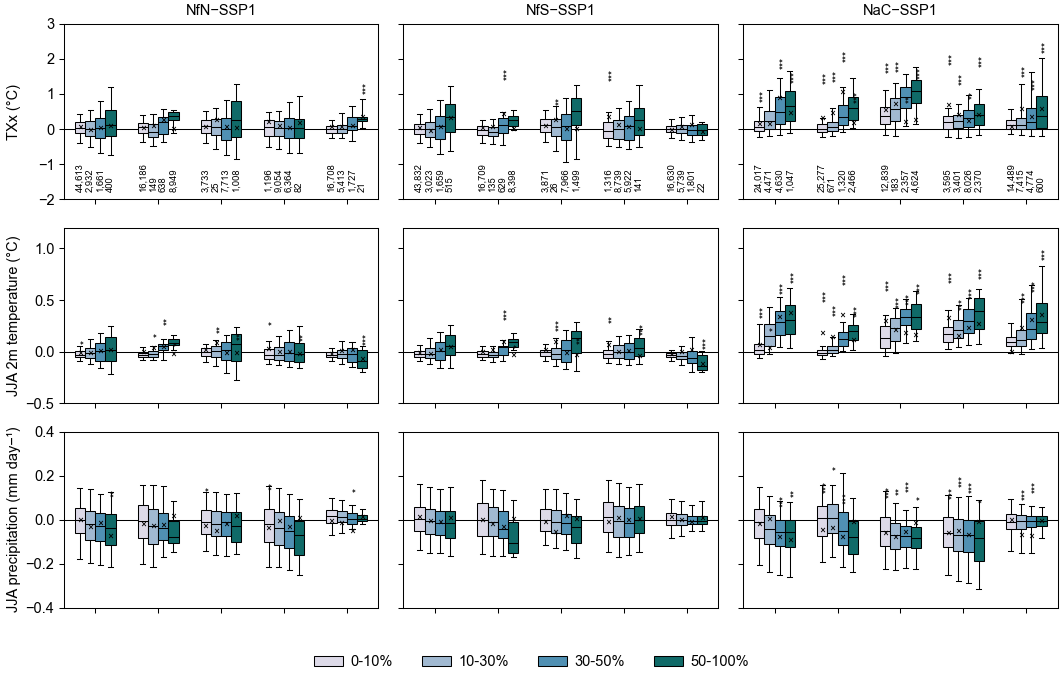

In [14]:
variables = ['TXx', 'T_2M', 'PRECIP']
row_headers = ['TXx (°C)', 'JJA 2m temperature (°C)', 'JJA precipitation (mm day−¹)']

# Boxes = spatial variation in climatology (without outliers)
fig, axes = plt.subplots(3,3, figsize=(double_width,4.5), sharex=True, sharey=False, constrained_layout=False)

add_headers(fig, col_headers=col_headers, row_headers=row_headers, row_pad=20, font='Arial', fontsize=7)
fig.subplots_adjust(hspace=0.16, wspace=0.08, left=0.06, right=0.995, bottom=0.1, top=0.965) # make space for labels and cbars; ignored if constrained_layout=True; left=0.005 without labels

for row,var in enumerate(variables):
    for col, (df_clim, df_series) in enumerate(zip(list_df_clim, list_df_series)):
        ax = axes[row,col]
        
        h = sns.boxplot(ax=ax, zorder=1, x="region", y=var, hue="perturb", data=df_clim, order=region_order, palette="PuBuGn", width=0.65, **opts,
                        showmeans=False, meanprops=dict(marker='x', markersize=2, markeredgewidth=0.5, markeredgecolor='red'), showfliers=False, flierprops=dict(marker='.', markersize=1),
                        whis=whis) # rocket_r
        h.legend_.remove()
    
        # Significance
        add_groupsize_labels(ax, h, df_clim, perturb_levels, region_order, var, whis, showmean=True, signif=True, signif_data=df_series)
    
        # Without sig filtering, groups are identical across variables. Add only on one variable.
        if row == 0:
            add_groupsize_labels(ax, h, df_clim, perturb_levels, region_order, var, whis, pos=-1.8)
        #if row == 2:
        #    add_groupsize_labels(ax, h, df_clim, perturb_levels, region_order, var, whis, pos=-0.38)

        if col>0:
            ax.set_yticklabels([])
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
        ax.axhline(0, color='black', linewidth=0.5, zorder=0);
    
        # # Make the first box (all levels) white and hatched
        # mpl.rcParams['hatch.linewidth'] = 0.4
        # all_boxes = [c for c in ax.get_children() if "Patch" in str(c)][0::len(perturb_levels)]
        # for box in all_boxes:
        #     box.set(facecolor='white', hatch ='///////')

        if row == 0:
            axes[0,col].set_ylim(-2, 3) # TXx
        if row == 1:
            axes[1,col].set_ylim(-0.5, 1.2) # T2m
        if row == 2:
            axes[2,col].set_ylim(-0.4, 0.4) # Precip

handles, labels = axes[0,0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='outside lower center', borderaxespad=0, frameon=False, ncols=len(perturb_levels))
#legend.legendHandles[0].set(facecolor='white', hatch ='///////')
for ha in legend.legendHandles:
    ha.set_edgecolor('black')

#plt.savefig(f'Figures/sensitivity/Fig6_boxplot.pdf')
plt.savefig(f'Figures/sensitivity/Fig6_boxplot.png')
plt.show()

## Supplementary (Supp. Fig. 5)

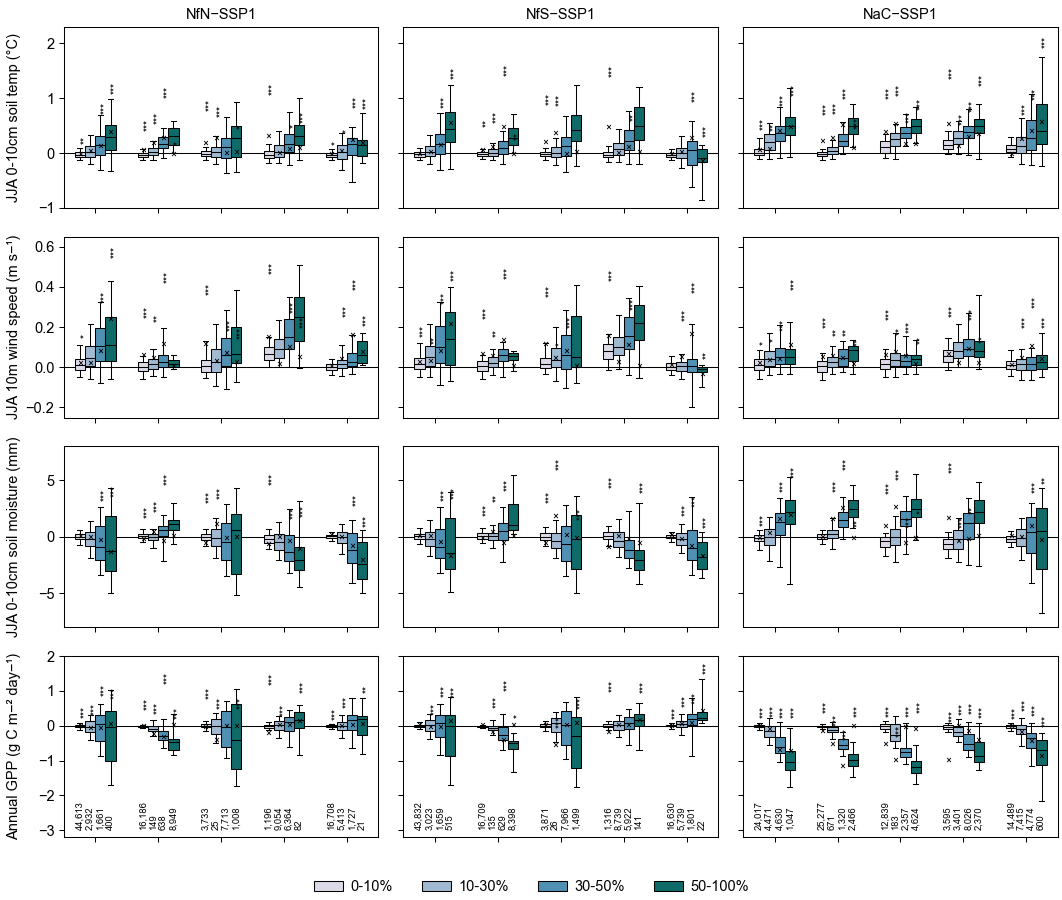

In [15]:
variables = ['TSOI_10CM', 'WIND_10M', 'SOILWATER_10CM', 'GPP']
row_headers = ['JJA 0-10cm soil temp (°C)', 'JJA 10m wind speed (m s−¹)', 'JJA 0-10cm soil moisture (mm)', 'Annual GPP (g C m−² day−¹)']

# Boxes = spatial variation in climatology (without outliers)
fig, axes = plt.subplots(4,3, figsize=(double_width,6), sharex=True, sharey=False, constrained_layout=False)

add_headers(fig, col_headers=col_headers, row_headers=row_headers, row_pad=20, font='Arial', fontsize=7)  
fig.subplots_adjust(hspace=0.16, wspace=0.08, left=0.06, right=0.995, bottom=0.07, top=0.97)  # make space for labels and cbars; ignored if constrained_layout=True; left=0.005 without labels

for row,var in enumerate(variables):
    for col, (df_clim, df_series) in enumerate(zip(list_df_clim, list_df_series)):
        ax = axes[row,col]
        
        h = sns.boxplot(ax=ax, zorder=1, x="region", y=var, hue="perturb", data=df_clim, order=region_order, palette="PuBuGn", width=0.65, **opts,
                        showmeans=False, meanprops=dict(marker='x', markersize=2, markeredgewidth=0.5, markeredgecolor='red'), showfliers=False, flierprops=dict(marker='.', markersize=1),
                        whis=whis) # rocket_r
        h.legend_.remove()
    
        # Significance
        add_groupsize_labels(ax, h, df_clim, perturb_levels, region_order, var, whis, showmean=True, signif=True, signif_data=df_series)
    
        # Without sig filtering, groups are identical across variables. Add only on one variable.
        if row == 3:
            add_groupsize_labels(ax, h, df_clim, perturb_levels, region_order, var, whis, pos=-3)

        if col>0:
            ax.set_yticklabels([])
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
        ax.axhline(0, color='black', linewidth=0.5, zorder=0);
    
        # # Make the first box (all levels) white and hatched
        # mpl.rcParams['hatch.linewidth'] = 0.4
        # all_boxes = [c for c in ax.get_children() if "Patch" in str(c)][0::len(perturb_levels)]
        # for box in all_boxes:
        #     box.set(facecolor='white', hatch ='///////')

        if row == 0:
            axes[0,col].set_ylim(-1, 2.3) # Tsoil
        if row == 1:
            axes[1,col].set_ylim(-0.25, 0.65) # Wind
        if row == 2:
            axes[2,col].set_ylim(-8, 8) # SM
        if row == 3:
            axes[3,col].set_ylim(-3.2, 2) # GPP

handles, labels = axes[0,0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='outside lower center', borderaxespad=0, frameon=False, ncols=len(perturb_levels))
#legend.legendHandles[0].set(facecolor='white', hatch ='///////')
for ha in legend.legendHandles:
    ha.set_edgecolor('black')

#plt.savefig(f'Figures/sensitivity/SM-Fig5_boxplot.pdf')
plt.savefig(f'Figures/sensitivity/SM-Fig5_boxplot.png')
plt.show()